The Plaicraft project is an initiative that collects data on how people play Minecraft. Specifically, a Minecraft server is run on the web and people enlisted in the initiative are able to play Minecraft in their browser. The initiative collects data on how people play, including a built in proximity voice chat to examine the interactions that are made within the game.

Within this report, we will be answering the following question: 
We want to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability. In order to determine this,
we will analyze the hour of the day, and the day of the week, and find during which time frames there are the most players, and how many players during those time frames.

We will be using the **sessions.csv** data set to answer our question, which includes $1535$ total observations, with $5$ columns (variables), including the data type of the variable:\
**hashedEmail (character)**: hashed email of players, hashed meaning that the emails have been encrypted to protect privacy\
**start_time (character)**: the time the player joins the Minecraft server, in the format Day/Month/Year Hour:Minute, in GMT\
**end_time (character)**: the time the player leaves the Minecraft server, in the format Day/Month/Year Hour:Minute, in GMT\
**original_start_time (double)**: the time the players joins the Minecraft server, in miliseconds since January $1$st, $1970$\
**original_end_time (double)**: the time the players leaves the Minecraft server, in miliseconds since January $1$st, $1970$

**Methods and Results**:
We first load **sessions.csv** and mutate our **sessions.csv** and add useful variables that will help our analysis. The following variables are added (if the same name was used, then the variable was overridden):\
**start_time (dttm)**: Original **start_time**, converted to dttm data type, added seconds, all set to :00\
**end_time (dttm)**: Original **start_time**, converted to dttm data type, added seconds, all set to :00\
**session_length (Double)**: The difference in seconds between the **end_time** and **start_time**\
**(5 separate variables) year_start (double), month_start (double), day_start (integer), hour_start (integer), minute_start (integer)**: The year, month, day, hour, minute of **start_time**, respectively.\
**(5 separate variables) year_end (double), month_end (double), day_end (integer), hour_end (integer), minute_end (integer)**: The year, month, day, hour, minute of **end_time**, respectively.\
**startwday (ordered factor)**: The day of the week of **start_time**\
**endwday (ordered factor)**: The day of the week of **end_time**

In [51]:
library(tidyverse)

sessions<-read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

sessions_tidy<-sessions|>
     mutate(start_time=paste(start_time,":00"),
     end_time=paste(end_time,":00"),
     start_time=dmy_hms(start_time),
     end_time=dmy_hms(end_time),
     session_length=int_length(interval(start_time,end_time)))|>
     select(start_time,end_time,session_length)|>
     mutate(year_start=year(start_time),month_start=month(start_time),day_start=day(start_time),
     hour_start=hour(start_time),minute_start=minute(start_time),startwday=wday(start_time,label=TRUE,abbr=TRUE))|>
     mutate(year_end=year(end_time),month_end=month(end_time),day_end=day(end_time),
     hour_end=hour(end_time),minute_end=minute(end_time),endwday=wday(end_time,label=TRUE,abbr=TRUE))

head(sessions_tidy)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `end_time = dmy_hms(end_time)`.
Caused by warning:
!  2 failed to parse.”


start_time,end_time,session_length,year_start,month_start,day_start,hour_start,minute_start,startwday,year_end,month_end,day_end,hour_end,minute_end,endwday
<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<ord>,<dbl>,<dbl>,<int>,<int>,<int>,<ord>
2024-06-30 18:12:00,2024-06-30 18:24:00,720,2024,6,30,18,12,Sun,2024,6,30,18,24,Sun
2024-06-17 23:33:00,2024-06-17 23:46:00,780,2024,6,17,23,33,Mon,2024,6,17,23,46,Mon
2024-07-25 17:34:00,2024-07-25 17:57:00,1380,2024,7,25,17,34,Thu,2024,7,25,17,57,Thu
2024-07-25 03:22:00,2024-07-25 03:58:00,2160,2024,7,25,3,22,Thu,2024,7,25,3,58,Thu
2024-05-25 16:01:00,2024-05-25 16:12:00,660,2024,5,25,16,1,Sat,2024,5,25,16,12,Sat
2024-06-23 15:08:00,2024-06-23 17:10:00,7320,2024,6,23,15,8,Sun,2024,6,23,17,10,Sun


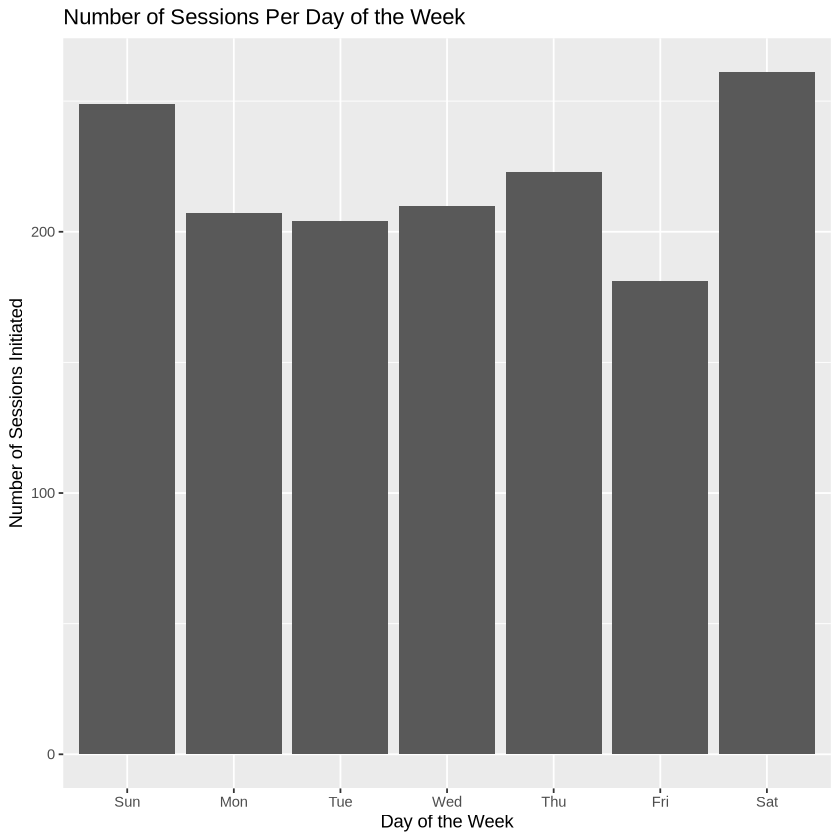

In [52]:
bydayofweek<-ggplot(sessions_tidy,aes(x=startwday))+
geom_bar()+
labs(x="Day of the Week",y="Number of Sessions Initiated") + 
ggtitle("Number of Sessions Per Day of the Week")
bydayofweek

Here, this bar graph shows that there were some trends in which day of the week had the highest plays. Interestingly, there were less sessions started on Friday compared to any other day. This graph shows that the weekends had higher playership. We can confirm this by obtaining the number of initiated sessions by day of the week, and then sorting in ascending order.

In [53]:
average_sessions_dayofweek <- sessions_tidy |>
    group_by(startwday) |>
    summarize(average_sessions = n()) |>
    arrange(average_sessions)

average_sessions_dayofweek

startwday,average_sessions
<ord>,<int>
Fri,181
Tue,204
Mon,207
Wed,210
Thu,223
Sun,249
Sat,261


From the tibble above, we observe that Saturday and Sunday has the most initiated sessions, which is what we observed from the bar graph.

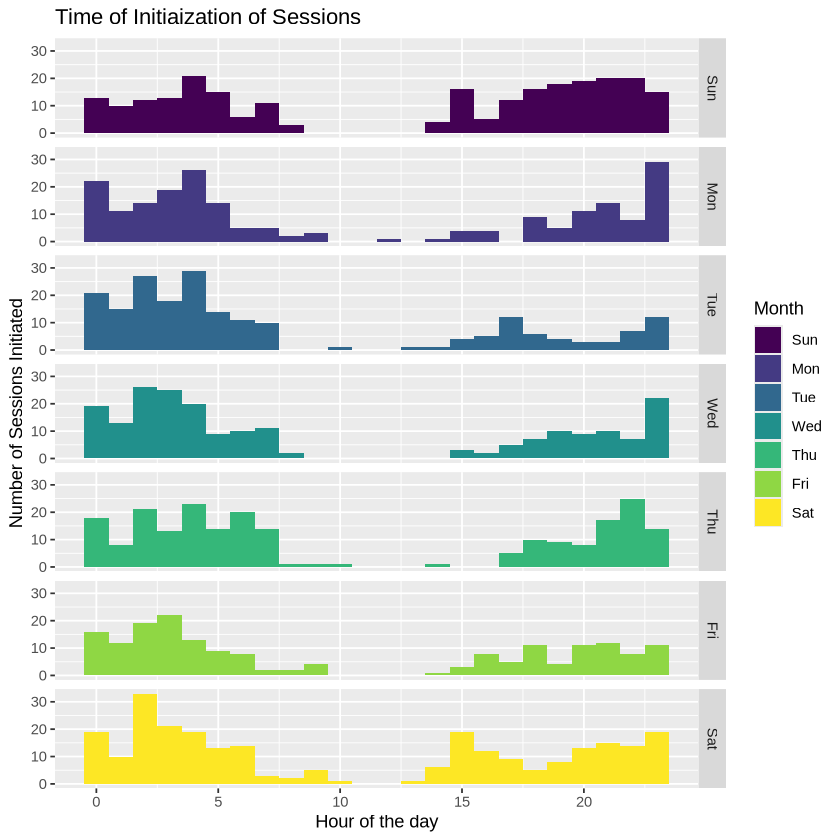

In [54]:
#this one needs to be redone to compensate for the potential lack of data in september
byhour<-ggplot(sessions_tidy,aes(x=hour_start,fill=as_factor(startwday)))+
geom_histogram(bins=24)+
facet_grid(rows = vars(startwday))+
labs(x="Hour of the day",y="Number of Sessions Initiated",fill="Month") + 
ggtitle("Time of Initiaization of Sessions")
byhour

Here we can see that most sessions are initated around 10pm to 5am.

Next, we want to plot a histogram of the number of sessions initiated on each day, from the first recorded observation to the last. We do this in order to see the activity by month. We can find out when the first and last observation is recorded by sorting **original_start_time** in ascneding order, then using the *head* and *tail* function to view the first and last observations, corresponding to earliest and latest observation, respectively.

In [55]:
library(dplyr)
sessions_ordered <- sessions %>% arrange(original_start_time)

head(sessions_ordered)
tail(sessions_ordered)

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,06/04/2024 09:35,06/04/2024 10:16,1.71240e+12,1.71240e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,06/04/2024 09:27,06/04/2024 09:31,1.71240e+12,1.71240e+12
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,06/04/2024 22:24,06/04/2024 23:33,1.71244e+12,1.71245e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,06/04/2024 20:56,06/04/2024 22:04,1.71244e+12,1.71244e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,07/04/2024 00:17,07/04/2024 00:28,1.71245e+12,1.71245e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,07/04/2024 02:08,07/04/2024 03:35,1.71246e+12,1.71246e+12


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
8e0aac3020b3fd9cdef4840b533b4b105aaf1ce1f6f2df3f328ba2a44cecfdc1,21/09/2024 00:22,21/09/2024 02:12,1.72688e+12,1.72688e+12
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,21/09/2024 05:07,21/09/2024 06:58,1.72690e+12,1.72690e+12
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,21/09/2024 21:13,21/09/2024 22:14,1.72695e+12,1.72696e+12
a175d4741dc84e6baf77901f6e8e0a06f54809a34e6b5211159bced346f7fb3e,21/09/2024 23:49,22/09/2024 00:23,1.72696e+12,1.72696e+12
7c0ae28a5f85a515a8063f9ed989aa26c5ebcc64f6b7be2948c0b300c2c9bd47,24/09/2024 06:30,24/09/2024 06:39,1.72716e+12,1.72716e+12
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,26/09/2024 06:09,26/09/2024 07:39,1.72733e+12,1.72734e+12


We can observe from the above that the earliest observation's start time is on April $6$th, $2024$, and the latest observation's start time is September $26$th, $2024$. Then, we can use this information for the histogram, and determine the bins. The bins should be equal to the days between the earliest observation and latest observation, inclusive, which is $174$.

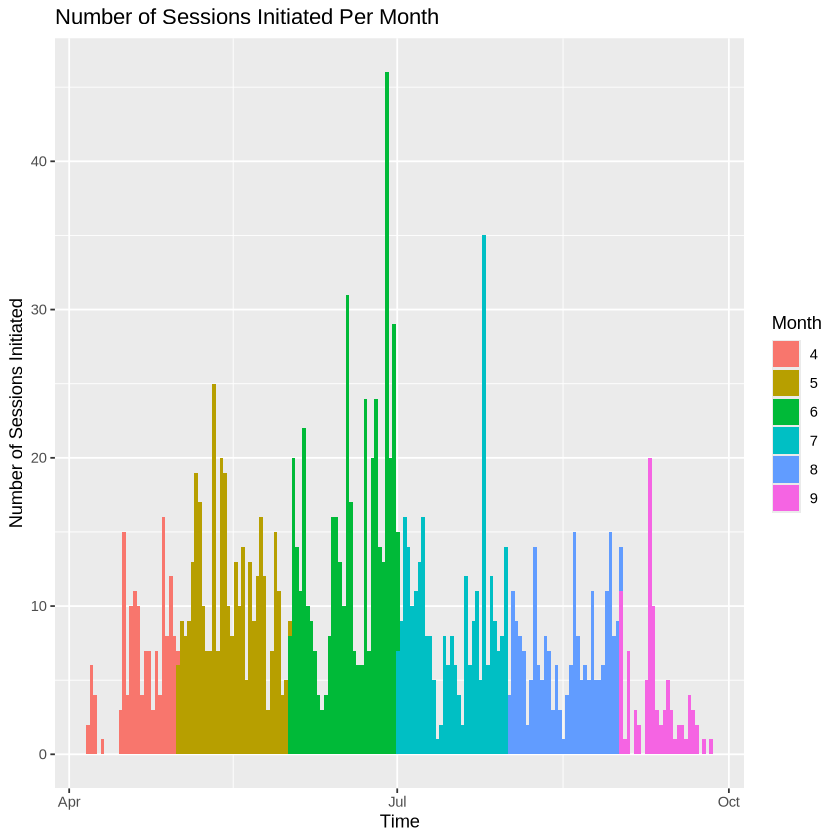

In [56]:
over_time<-ggplot(sessions_tidy,aes(x=start_time, fill = as_factor(month_start)))+
geom_histogram(bins=174)+
labs(x="Time",y="Number of Sessions Initiated",
     fill = "Month")+
ggtitle("Number of Sessions Initiated Per Month")
over_time

From the histogram above, with each bin representing one day, we can observe that June has the most activity. To confirm this, we can put it into numbers and see the number of observations by month, and then sort it in ascending order.

In [57]:
sessions_count <- sessions_tidy |>
    group_by(month_start) |>
    summarize(sessions_initiated = n()) |>
    arrange(sessions_initiated)

sessions_count

month_start,sessions_initiated
<dbl>,<int>
9,92
4,143
8,221
7,288
5,344
6,447


From the tibble above, we can see that June has the most sessions $447$, which is what we observed from the histogram. We can also see that September has the least number of sessions, at $92$

Warning message:
“Removed 475 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 14 rows containing missing values or values outside the scale range
(`geom_bar()`).”


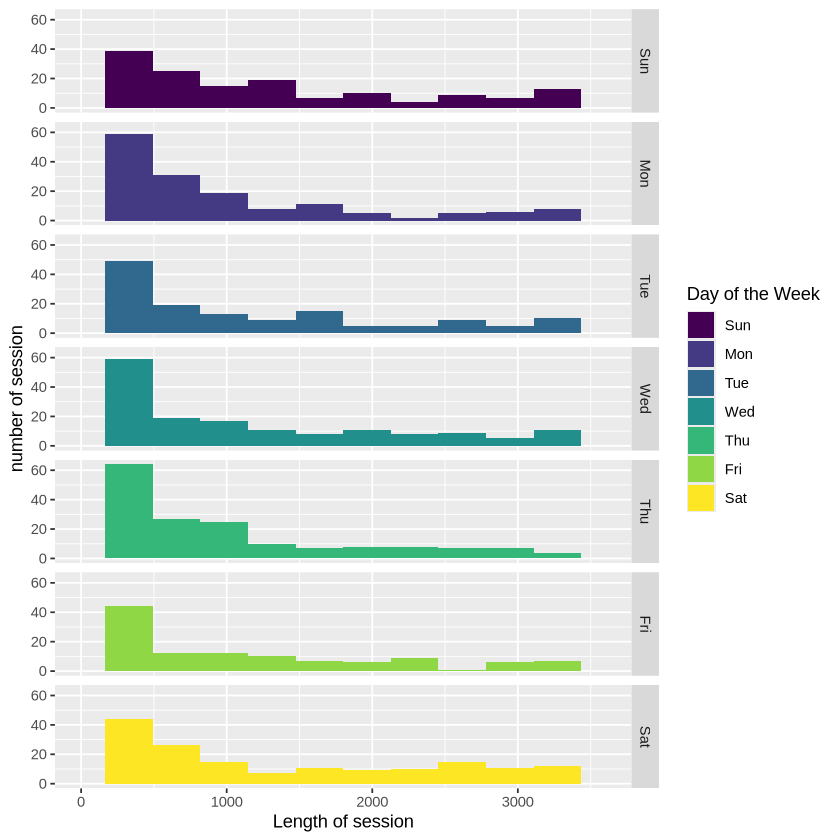

In [58]:
#may want to make this into a logarithmic scale without limits. 
#From this and the number of sessions, we can determine the possibility of having x amount of players on simultaneously.
#also, change to size to a larger, more readable size.
duration<-ggplot(sessions_tidy,aes(x=session_length,fill=startwday))+
geom_histogram(bins=12)+
facet_grid(rows = vars(startwday))+
labs(x="Length of session",y="number of session",fill="Day of the Week")+
xlim(c(0,3600))
duration

start_time,end_time,session_length,year_start,month_start,day_start,hour_start,minute_start,startwday,dayofweek
<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<ord>,<dbl>
2024-06-30 18:12:00,2024-06-30 18:24:00,720,2024,6,30,18,12,Sun,7.758333
2024-06-17 23:33:00,2024-06-17 23:46:00,780,2024,6,17,23,33,Mon,1.981250
2024-07-25 17:34:00,2024-07-25 17:57:00,1380,2024,7,25,17,34,Thu,4.731944
2024-07-25 03:22:00,2024-07-25 03:58:00,2160,2024,7,25,3,22,Thu,4.140278
2024-05-25 16:01:00,2024-05-25 16:12:00,660,2024,5,25,16,1,Sat,6.667361
2024-06-23 15:08:00,2024-06-23 17:10:00,7320,2024,6,23,15,8,Sun,7.630556


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


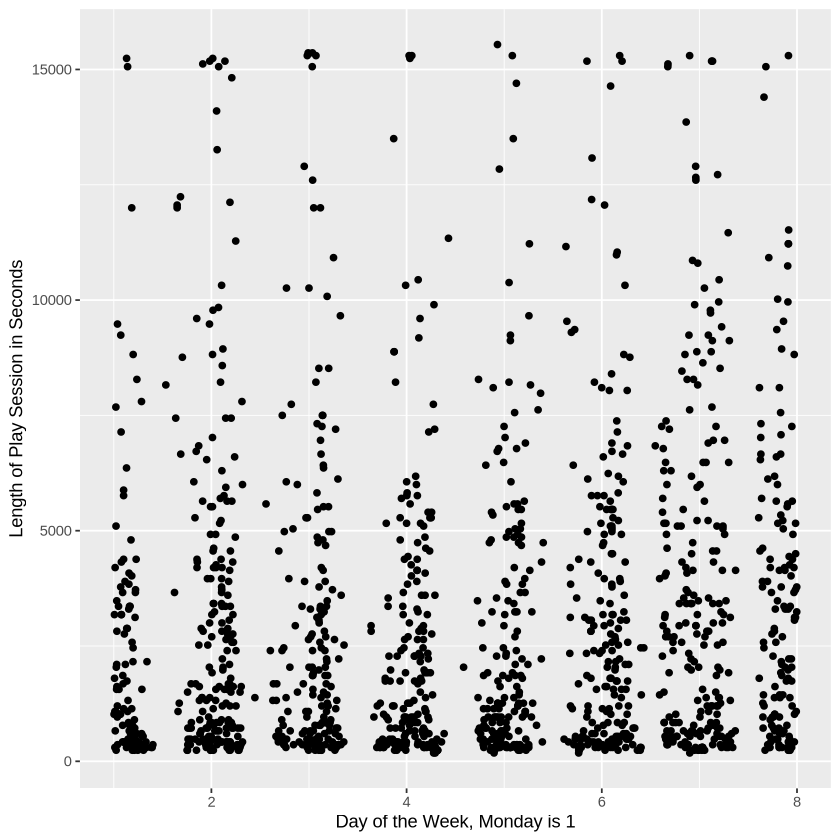

In [59]:
#potential ideas
#group by each day, and then look at which days had the most play time. 
#could cheack each minute to see how many people are on. this would be done by editing the initial session_tidy
#session_length column into two steps, one for the interval and one for the session length
#select all weekends and then graph the playership of the weekends over time.
     
#concept: Change day of the week to a variable based on hour and minute
session_scale_wday<-sessions_tidy|>
select(start_time:startwday)|>
mutate(dayofweek=wday(start_time,label=FALSE,week_start=1)+(minute_start/60+hour_start)/24)
head(session_scale_wday)
session_length_wday<-session_scale_wday|>
ggplot(aes(x=dayofweek,y=session_length))+
geom_point()+
labs(x="Day of the Week, Monday is 1",y="Length of Play Session in Seconds")
session_length_wday
#then do clustering on play time and day of the week

In [60]:
clusnums<-tibble(num_clusters=1:20)
scaleday_recipe<-recipe(~dayofweek,data=session_scale_wday)|>
step_scale(all_predictors())|>
step_center(all_predictors())
wday_spec_tune <- k_means(num_clusters = tune()) |>
        set_engine("stats",nstart=10)
#3
elbow_stats <- workflow() |>
        add_recipe(scaleday_recipe) |>
        add_model(wday_spec_tune) |>
        tune_cluster(resamples = apparent(session_scale_wday), grid = clusnums) |>
        collect_metrics()|>
#4
        filter(.metric=="sse_within_total")|>
        mutate(total_WSSD=mean)|>
        select(num_clusters,total_WSSD)
elbow_stats

ERROR: Error in step_center(step_scale(recipe(~dayofweek, data = session_scale_wday), : could not find function "step_center"


In [ ]:
elbow_plot1<-ggplot(elbow_stats,aes(x=num_clusters,y=total_WSSD))+
geom_point()+
geom_line()+
labs(x="Number of clusters", y="Total WSSD")+
xlim(c(5,20))+
ylim(c(0,100))
# No Answer - remove if you provide an answer

elbow_plot2<-ggplot(elbow_stats,aes(x=num_clusters,y=total_WSSD))+
geom_point()+
geom_line()+
labs(x="Number of clusters", y="Total WSSD")
# No Answer - remove if you provide an answer
elbow_plot1
elbow_plot2